In [8]:
import numpy as np
import alphashape
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import geopandas as gpd
import random
from shapely.geometry import Point
from pprint import pprint

In [9]:
def isMultiPoly(x):
    return isinstance(x, shapely.geometry.multipolygon.MultiPolygon)

def isPoly(x):
    return isinstance(x, shapely.geometry.polygon.Polygon)

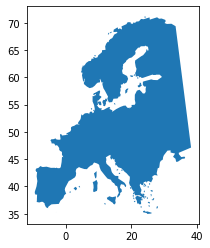

In [10]:
shapefile = '/home/helge/Applications/matsim/Shapes/DEU_adm/DEU_adm0.shp'
shapefile = '/home/helge/Applications/EuropeGIS/my_continental_europe.shp'

gdf = gpd.read_file(shapefile)

# gdf["geometry"] = gdf["geometry"].apply(lambda x: max(x, key=lambda a: a.area) if isMultiPoly(x) else x)
# gdf["main_poly"] = gdf["geometry"].apply(lambda x: x if isMulti(x) else 42)
polygons = gdf.loc[0,"geometry"]
# display(gdf)
gdf.plot()
plt.show()

In [77]:
main_poly = max(polygons, key=lambda a: a.area)

def generate_random(number, polygon):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

points_in_poly = generate_random(1000, main_poly)
coords = np.array([[p.x, p.y] for p in points_in_poly])

In [78]:
exterior = np.stack(main_poly.exterior.coords.xy, axis=1)

# Method 1
# def distToNext(p, points):
#     dists = np.sqrt((points[:,0] - p[0])**2 + (points[:,1] - p[1])**2)
#     dists = dists[dists != 0]
#     return dists.min()

# weights = [distToNext(p, exterior)**1.5 for p in exterior]
# weights /= np.sum(weights)
# ext_sample_idx = np.random.choice(np.arange(len(exterior)), p=weights, size=300)
# ext_sample = exterior[ext_sample_idx]

# Method 2
# minx = exterior[:,0].min()
# maxx = exterior[:,0].max()
# miny = exterior[:,1].min()
# maxy = exterior[:,1].max()
# Δx = maxx - minx + 0.001
# Δy = maxy - miny + 0.001

# n = 20
# bins = []
# for i in range(n):
#     bins.append([])
#     for j in range(n):
#         bins[i].append([])

# for p in exterior:
#     idxx = (int((p[0]-minx)/Δx * n))
#     idxy = (int((p[1]-miny)/Δy * n))
#     bins[idxx][idxy].append(p) 

# print(bins)
# bins_flat = [p for p in b for b in bins]
# print(bins_flat)

# ext_sample = []
# for i,b in enumerate(bins_flat):
#     if len(b) > 0:
#         idx = np.random.choice(range(len(b)), size=10)
#         p_list = np.array(b)[idx]
#         ext_sample.append(p_list)

# ext_sample = np.concatenate(ext_sample)

# Method 3
def single_parametric_interpolate(obj_x_loc,obj_y_loc,numPts=50):
    n = len(obj_x_loc)
    vi = [[obj_x_loc[(i+1)%n] - obj_x_loc[i],
         obj_y_loc[(i+1)%n] - obj_y_loc[i]] for i in range(n)]
    si = [np.linalg.norm(v) for v in vi]
    di = np.linspace(0, sum(si), numPts, endpoint=False)
    new_points = []
    for d in di:
        for i,s in enumerate(si):
            if d>s: d -= s
            else: break
        l = d/s
        new_points.append([obj_x_loc[i] + l*vi[i][0],
                           obj_y_loc[i] + l*vi[i][1]])
    return np.array(new_points)

ext_sample = single_parametric_interpolate(exterior[:,0], exterior[:,1], 200)

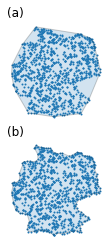

In [103]:
sample_idx = np.random.choice(np.arange(len(coords)), size=1000)
int_sample = coords[sample_idx]
sample = np.concatenate((int_sample, ext_sample))
# sample = test


minx = exterior[:,0].min()
maxx = exterior[:,0].max()
miny = exterior[:,1].min()
maxy = exterior[:,1].max()
Δx = maxx - minx
Δy = maxy - miny

fig, (ax1, ax2) = plt.subplots(2,1)#,constrained_layout=True)

alpha_shape1 = alphashape.alphashape(sample, 0)
poly1 = PolygonPatch(alpha_shape1, alpha=0.2)
ax1.add_patch(poly1)
alpha_shape2 = alphashape.alphashape(sample, 2.5)
poly2 = PolygonPatch(alpha_shape2, alpha=0.2)
ax2.add_patch(poly2)

ax1.scatter(sample[:,0], sample[:,1], s=1)
ax2.scatter(sample[:,0], sample[:,1], s=1)
ax1.set_aspect(Δx/Δy)
ax2.set_aspect(Δx/Δy)
ax1.axis("off")
ax2.axis("off")
# fig.suptitle(r"$\alpha>0$")
ax1.set_title("(a)", loc="left")
ax2.set_title("(b)", loc="left")

fig.savefig("Figures/GermanyAlphaDemonstration.pgf", bbox_inches="tight")

plt.show()